In [6]:
#!pip install --upgrade tensorflow==2.12.0
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn

  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 991.0 kB/s eta 0:00:11
   ---------------------------------------- 0.1/10.6 MB 1.3 MB/s eta 0:00:08
   ---------------------------------------- 0.1/10.6 MB 901.1 kB/s eta 0:00:12
    --------------------------------------- 0.3/10.6 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/10.6 MB 1.6 MB/s eta 0:00:07
   - -------------------------------------- 0.5/10.6 MB 1.7 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/10.6 MB 1.9 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/10.6 MB 1.9 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/10.6 MB 2.1 MB/s eta 0:00:05
   --- ------------------------

In [1]:
#!pip install --upgrade tensorflo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML



In [2]:
#pip show tensorflow

### iterate through the folders to create a dataframe of the form filepaths labels

In [3]:
data=r'C:/Users/ASUS/Nandang/datasetbalance/train/'

filepaths=[]
labels=[]
classlist=os.listdir(data)
for klass in classlist:
    classpath=os.path.join(data,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  C:/Users/ASUS/Nandang/datasetbalance/train/bad...  bad_welding
1  C:/Users/ASUS/Nandang/datasetbalance/train/bad...  bad_welding
2  C:/Users/ASUS/Nandang/datasetbalance/train/bad...  bad_welding
3  C:/Users/ASUS/Nandang/datasetbalance/train/bad...  bad_welding
4  C:/Users/ASUS/Nandang/datasetbalance/train/bad...  bad_welding
labels
bad_welding     461
crack           461
good_welding    461
pores           461
Name: count, dtype: int64


### split df into train_df, test_df and valid_df

In [4]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1475   test_df length:  184   valid_df length:  185


### create train, test, valid  generators

In [5]:
height=128
width=128
channels=3
batch_size=32

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    shear_range=0.2,
    fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    shear_range=0.2,
    fill_mode='nearest'
    )
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    shear_range=0.2,
    fill_mode='nearest'
    )
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  46   test steps:  4
Found 1475 validated image filenames belonging to 4 classes.
Found 185 validated image filenames belonging to 4 classes.
Found 184 validated image filenames belonging to 4 classes.
['bad_welding', 'crack', 'good_welding', 'pores']


In [6]:
samples = train_gen.samples
print(samples)

1475


### create function to show some image examples

In [7]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

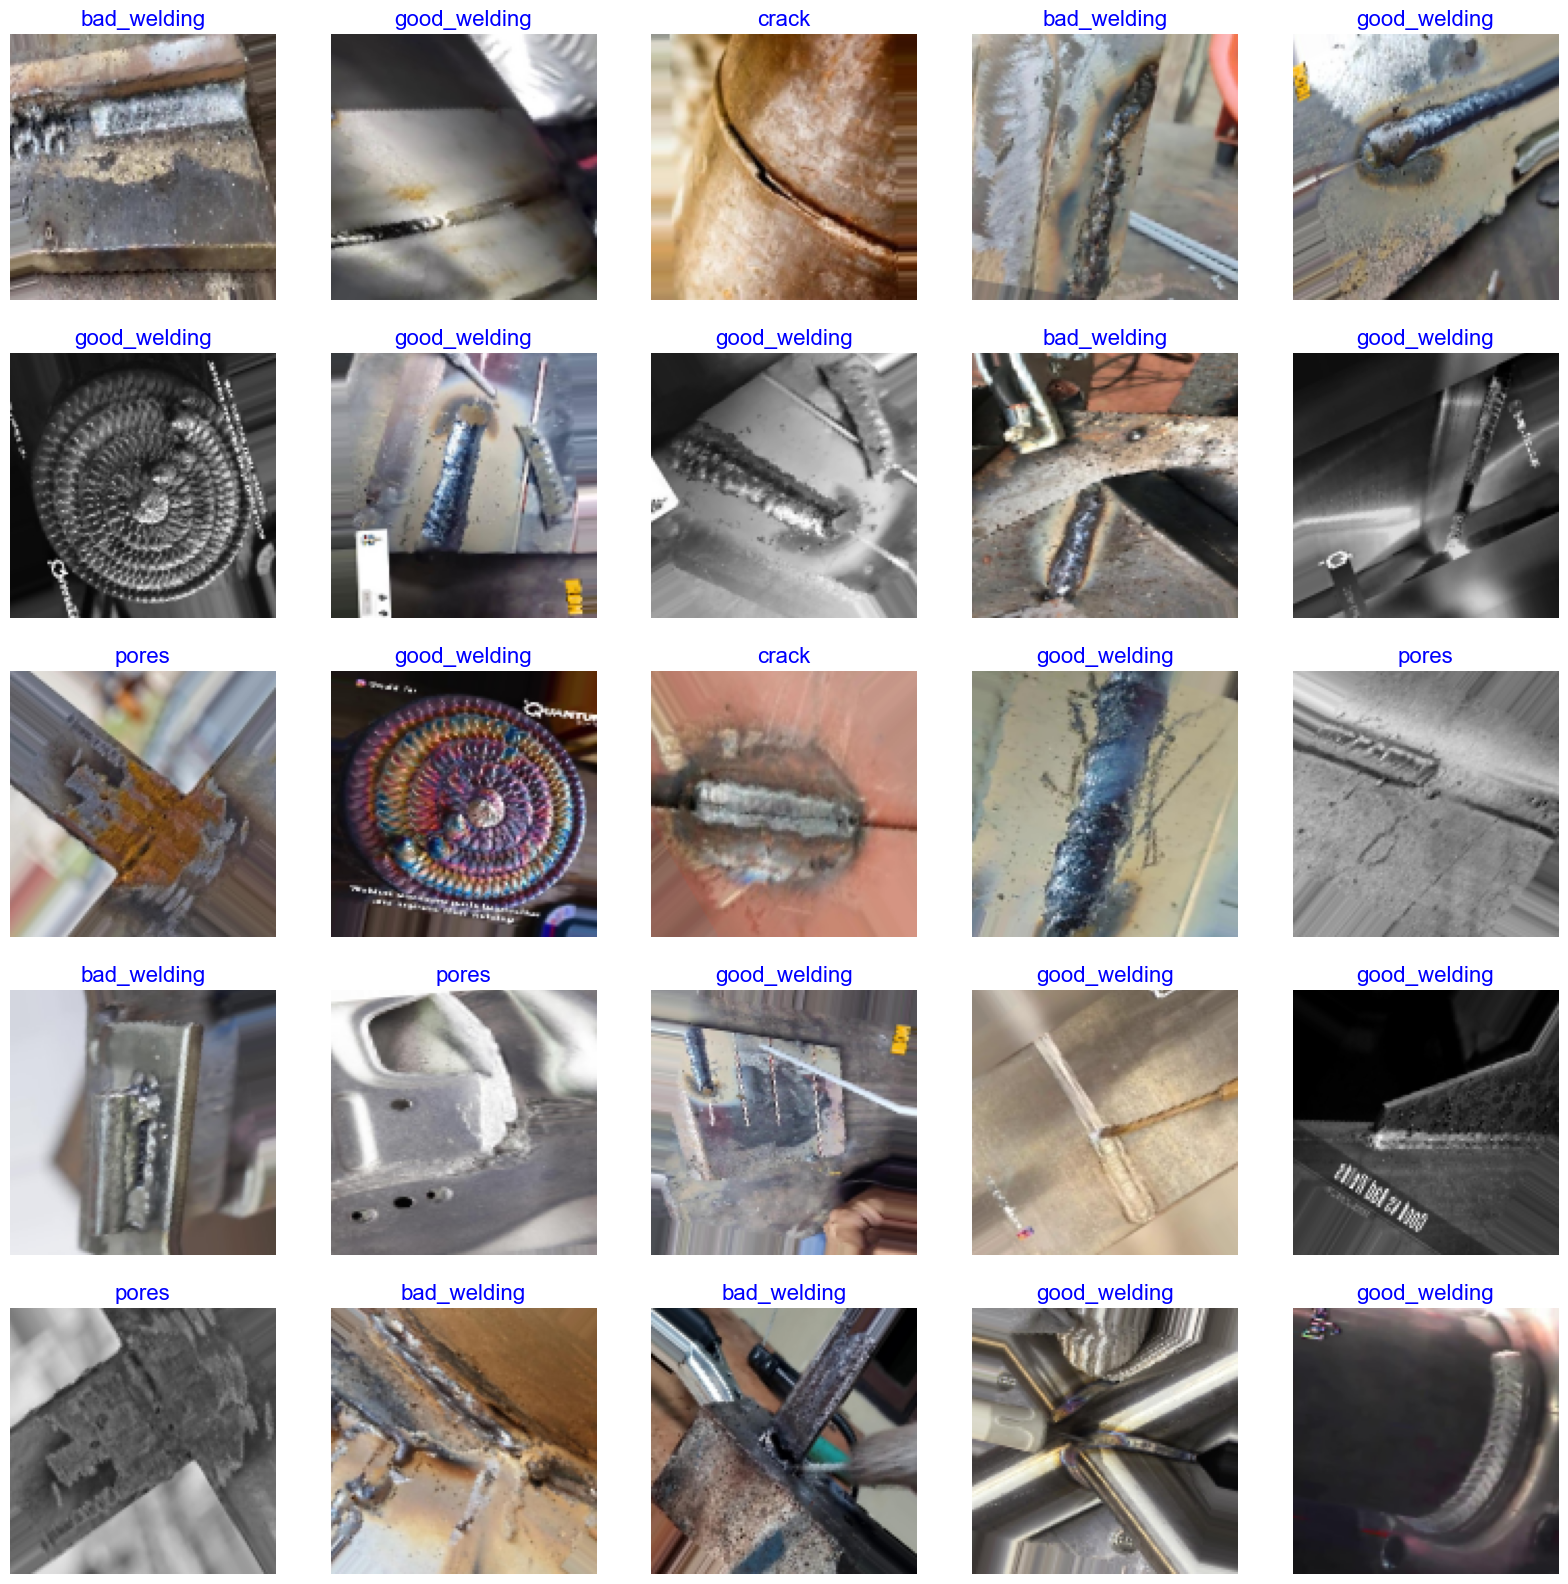

In [8]:
show_image_samples(train_gen)

### create the model

In [9]:
base_model=tf.keras.applications.Xception(weights="imagenet",input_tensor=Input(shape=(128,128,3)),include_top=False) 

In [10]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [11]:
base_model.trainable = False 

In [12]:
model_name='Mobile'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4,activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Building model with <keras.engine.functional.Functional object at 0x000002603D90D710>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None,

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                    

In [14]:
epochs =100
history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/100
47/47 [==============================] - 68s 1s/step - loss: 1.2708 - accuracy: 0.4258 - val_loss: 0.9190 - val_accuracy: 0.6270
Epoch 2/100
47/47 [==============================] - 54s 1s/step - loss: 0.8960 - accuracy: 0.6475 - val_loss: 0.6056 - val_accuracy: 0.7784
Epoch 3/100
47/47 [==============================] - 55s 1s/step - loss: 0.7068 - accuracy: 0.7525 - val_loss: 0.4732 - val_accuracy: 0.8595
Epoch 4/100
47/47 [==============================] - 56s 1s/step - loss: 0.5721 - accuracy: 0.7953 - val_loss: 0.5250 - val_accuracy: 0.8270
Epoch 5/100
47/47 [==============================] - 56s 1s/step - loss: 0.5114 - accuracy: 0.8231 - val_loss: 0.3057 - val_accuracy: 0.8919
Epoch 6/100
47/47 [==============================] - 56s 1s/step - loss: 0.4641 - accuracy: 0.8427 - val_loss: 0.3015 - val_accuracy: 0.9081
Epoch 7/100
47/47 [==============================] - 56s 1s/step - loss: 0.4147 - accuracy: 0.8576 - val_loss: 0.3322 - val_accuracy: 0.8919
Epoch 8/100
4

In [15]:
model.evaluate(test_gen)
preds = model.predict(test_gen)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_gen.labels)

4/4 [==============================] - 6s 1s/step


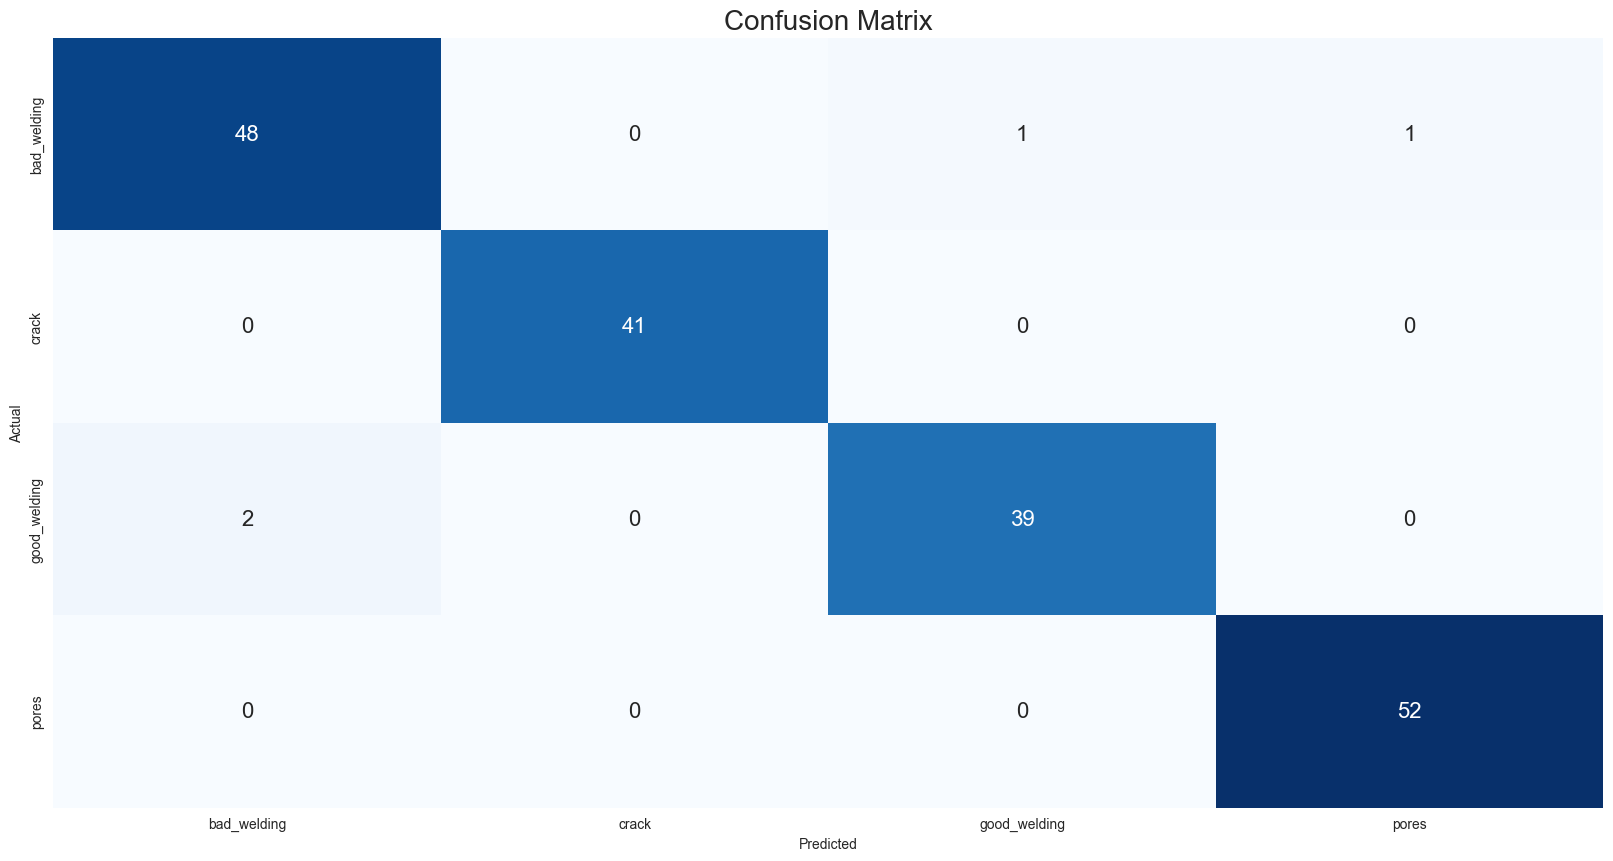

In [16]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=classes, index = classes)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [17]:
print('Classification Report')
print(classification_report(y_test, y_preds, target_names=classes))

Classification Report
              precision    recall  f1-score   support

 bad_welding       0.96      0.96      0.96        50
       crack       1.00      1.00      1.00        41
good_welding       0.97      0.95      0.96        41
       pores       0.98      1.00      0.99        52

    accuracy                           0.98       184
   macro avg       0.98      0.98      0.98       184
weighted avg       0.98      0.98      0.98       184



### evaluate model on the test set then save the model

In [18]:

save_dir=r'./'
subject='ExceptionBalance'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

4/4 [==============================] - 4s 969ms/step - loss: 0.1669 - accuracy: 0.9402


In [10]:
from keras.models import load_model
model = load_model('Mobile-rice-96.92.h5')

In [11]:
y_prob = model.predict(test_gen)

109/109 [==============================] - 114s 1s/step


In [ ]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")